In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
##from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [2]:
# Use your local dataset path
data_dir = r'C:/Users/USER/anaconda3/project/train'  # Use raw string to handle backslashes

In [3]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(384, 512),
    batch_size=32,
    label_mode='int'  # Integer labels for sparse cross-entropy
)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(384, 512),
    batch_size=32,
    label_mode='int'
)

Found 3600 files belonging to 9 classes.
Using 2880 files for training.
Found 3600 files belonging to 9 classes.
Using 720 files for validation.


In [4]:
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras.applications import ResNet50

# Initialize the Sequential model
resnet_model = Sequential()

# Load the pretrained ResNet50 model without the top layer
pretrained_model = ResNet50(
    include_top=False,
    input_shape=(384, 512, 3),  # Explicit input shape
    weights='imagenet'
)

# Freeze the layers to avoid training the pretrained model
for layer in pretrained_model.layers:
    layer.trainable = False

# Add the pretrained model and additional layers
resnet_model.add(pretrained_model)
resnet_model.add(GlobalAveragePooling2D())  # Converts to (None, 2048)

# Add dense layers for classification
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(9, activation='softmax'))

# Build the model with input shape for batch prediction
resnet_model.build(input_shape=(None, 384, 512, 3))

# Print model summary to verify layer shapes
resnet_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 12, 16, 2048)        │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           4,617 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,641,417 (94.00 MB)

 Trainable params: 1,053,705 (4.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [5]:
resnet_model.compile(
    optimizer=Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

for images, labels in train_ds.take(1):
    print("Image batch shape: ", images.shape)
    print("Label batch shape: ", labels.shape)
    print("Sample labels: ", labels)


Image batch shape:  (32, 384, 512, 3)
Label batch shape:  (32,)
Sample labels:  tf.Tensor([6 7 7 2 0 6 3 0 5 8 6 0 6 8 7 5 1 8 2 8 6 1 6 8 4 4 8 2 0 4 8 4], shape=(32,), dtype=int32)


In [6]:
epochs = 10
history = resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)


Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 451s 5s/step - accuracy: 0.4328 - loss: 1.8262 - val_accuracy: 0.8167 - val_loss: 0.6640
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 442s 5s/step - accuracy: 0.8392 - loss: 0.5637 - val_accuracy: 0.8681 - val_loss: 0.4519
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 445s 5s/step - accuracy: 0.9098 - loss: 0.3343 - val_accuracy: 0.9097 - val_loss: 0.3196
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 466s 5s/step - accuracy: 0.9377 - loss: 0.2297 - val_accuracy: 0.9431 - val_loss: 0.2133
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 468s 5s/step - accuracy: 0.9663 - loss: 0.1511 - val_accuracy: 0.9472 - val_loss: 0.1786
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 463s 5s/step - accuracy: 0.9687 - loss: 0.1170 - val_accuracy: 0.9500 - val_loss: 0.1832
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 466s 5s/step - accuracy: 0.9871 - loss: 0.0811 - val_accuracy: 0.9486 - val_loss: 0.1818
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 459s 5s/step - accuracy: 0.9780 - loss: 0.0859 - val_accuracy: 0.9736 - v

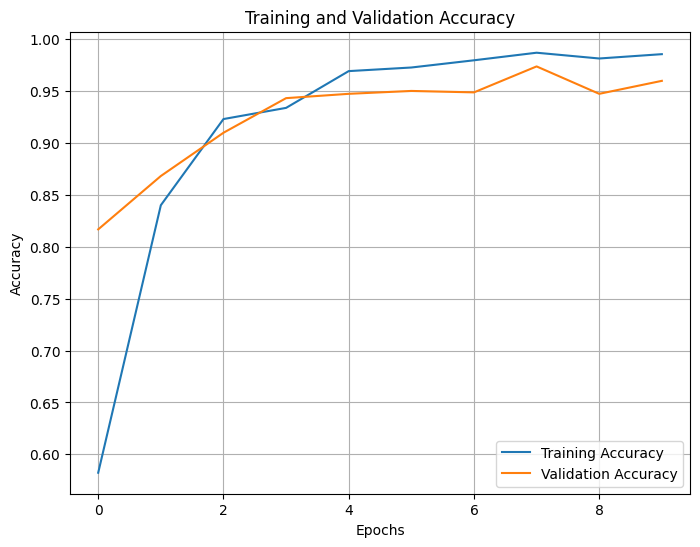

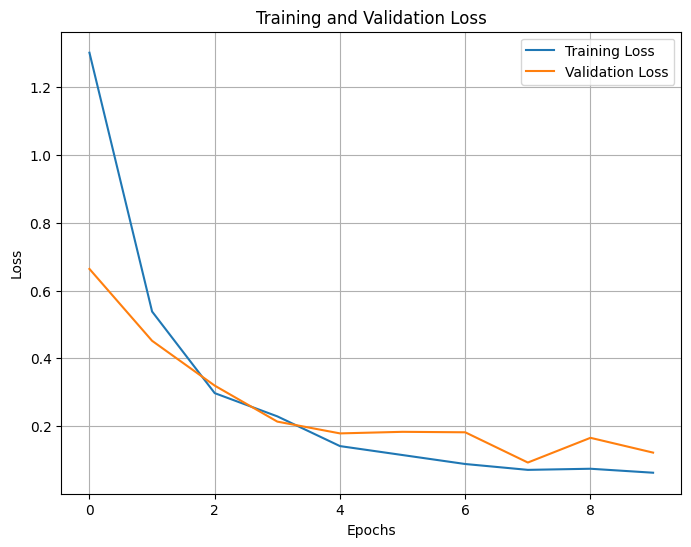

In [7]:
# Plotting training and validation accuracy
def plot_accuracy(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Plotting training and validation loss
def plot_loss(history):
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# Plot accuracy and loss
plot_accuracy(history)
plot_loss(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


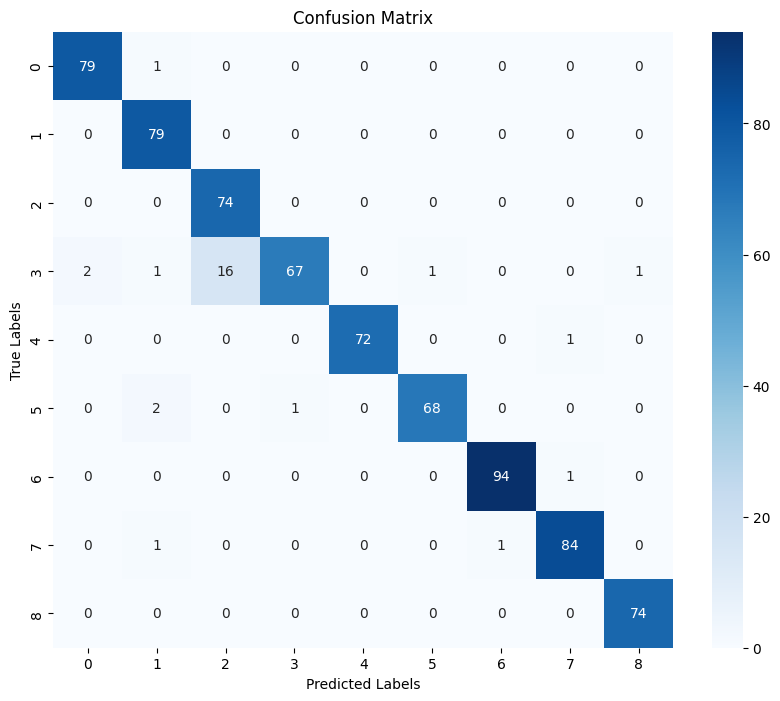

In [8]:
# Confusion Matrix
def plot_confusion_matrix(model, dataset):
    # Get true labels and predictions
    true_labels = []
    predictions = []
    for images, labels in dataset:
        preds = model.predict(images)
        true_labels.extend(labels.numpy())
        predictions.extend(np.argmax(preds, axis=1))

    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(true_labels),
                yticklabels=np.unique(true_labels))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

plot_confusion_matrix(resnet_model, val_ds)

In [9]:
# Additional Evaluation Metrics
def evaluate_model(model, dataset):
    true_labels = []
    predictions = []
    for images, labels in dataset:
        preds = model.predict(images)
        true_labels.extend(labels.numpy())
        predictions.extend(np.argmax(preds, axis=1))

    print("Classification Report:")
    print(classification_report(true_labels, predictions, target_names=[str(i) for i in range(9)]))

evaluate_model(resnet_model, val_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98        80
           1       0.94      1.00      0

In [10]:
import pickle

# Save history
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

print("Training history saved as 'training_history.pkl'")

Training history saved as 'training_history.pkl'


In [11]:

# Save the model in .keras format
resnet_model.save('Resnetmodel_final.keras')
